# <font color = '#00CCFF'> High Value Customer Identification </font>

Project Objective: Find significant customers for the business who make high purchases of their favourite products. The organization wants to roll out a loyalty program to the high-value customers after identification of segments. Use the clustering methodology to segment customers into groups:

Dataset Description: This is a transnational dataset that contains all the transactions occurring between Nov-2016 to Dec-2017 for a UK-based online retail store.

Attribute Description:
- InvoiceNo: Invoice number (A 6-digit integral number uniquely assigned to each transaction)
- StockCode: Product (item) code
- Description: Product (item) name
- Quantity: The quantities of each product (item) per transaction
- InvoiceDate: The day when each transaction was generated
- UnitPrice: Unit price (Product price per unit)
- CustomerID: Customer number (Unique ID assigned to each customer)
- Country: Country name (The name of the country where each customer resides)

# 0. Imports

## 0.1. Libraries

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import plotly.express as px
#%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import umap.umap_ as umap

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#from ydata_profiling import ProfileReport

## 0.2. Functions

In [2]:
# Save intermediate dataset
def save_interim(dataframe, file_name):
   dataframe.to_csv('../data/interim/'+file_name+'.zip', index=False, compression= 'zip')

# Load intermediate dataset
def load_interim(file_name):
   return pd.read_csv('../data/interim/'+file_name, compression='zip')

## 0.3. Load dataset

In [3]:
path = '/home/ezequiel/Documentos/Comunidade_DS/insiders_clustering/data/raw/Ecommerce.zip'
df_raw = pd.read_csv(path, encoding='unicode_escape', compression='zip')
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

In [13]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1. Descrição dos dados

In [4]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [15]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

## 1.2. Data dimensions

In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data types

InvoiceNo should be a number, but some records have letters

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [8]:
df1 = df1.dropna(subset=['description', 'customer_id'])

In [9]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change dtyper

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [10]:
# invoice_date -> to datetime
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id -> to int
df1['customer_id'] = df1['customer_id'].astype(int)

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [11]:
save_interim(dataframe=df1, file_name='df1.csv')

## 1.7. Descriptive statistics

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include='object')

### 1.7.1. Numerical attributes

In [13]:
df_describe = num_attributes.describe().T
df_describe['range'] = df_describe['max'] - df_describe['min']
df_describe['median'] = num_attributes.median()
df_describe['skewness'] = num_attributes.skew()
df_describe['kurtosis'] = num_attributes.kurtosis()
df_describe.reset_index()

,index,count,mean,std,min,25%,50%,75%,max,range,median,skewness,kurtosis
0,quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0,161990.0,5.00,0.182663,94317.563673
1,unit_price,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0,38970.0,1.95,452.219019,246924.542988
2,customer_id,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0,5941.0,15152.00,0.029835,-1.179982


<font color='red'>**OBSERVAÇÕES:**</font>
- quantity com mínimo negativo (devolução?)
- quantity com valor max e min iguais em módulo
- unit_price com min = zero (promoção?)

### 1.7.2. Categorical attributes

#### Invoice_no

In [14]:
# verifica se invoice_no contém, ao menos, uma letra e agrupa por invoice_no para o dataframe inteiro
aux = df1[df1['invoice_no'].str.contains('[a-zA-Z]')].groupby('invoice_no').count().reset_index()
print(f'Qtd de invoices únicos com letras: {len(aux)}')
print(f'Qtd total de invoices com letras {aux["stock_code"].sum()}')

Qtd de invoices únicos com letras: 3654
Qtd total de invoices com letras 8905


In [15]:
aux = len(df1.loc[df1['invoice_no'].str.contains('[a-zA-Z]'), ['quantity']])
print(f'Qtd de invoices com letras onde a quantidade é negativa: {aux}')

Qtd de invoices com letras onde a quantidade é negativa: 8905


#### Stock_code

In [16]:
# verifica se stock_code contém, ao menos, uma letra e conta quantos são
df1[df1['stock_code'].str.contains('[a-zA-Z]')]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom
45,536370,POST,POSTAGE,3,2016-11-29,18.00,12583,France
...,...,...,...,...,...,...,...,...
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2017-12-07,4.15,12713,Germany
541809,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2017-12-07,1.79,17581,United Kingdom
541838,581580,84993A,75 GREEN PETIT FOUR CASES,2,2017-12-07,0.42,12748,United Kingdom
541844,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,2017-12-07,1.25,12748,United Kingdom


In [17]:
# verifica se stock_code contém somente letras e mostra a quantidade de ocorrências
df1.loc[~df1['stock_code'].str.contains('[0-9]'), 'stock_code'].value_counts()

stock_code
POST            1196
M                465
D                 77
DOT               16
CRUK              16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64

In [18]:
lin = df1['stock_code'] == 'BANK CHARGES'
col = ['quantity', 'unit_price']
df1.loc[lin, col].sum()

quantity       12.000
unit_price    165.001
dtype: float64

In [19]:
lin = df1['stock_code'] == 'CRUK'
col = ['quantity', 'unit_price']
df1.loc[lin, col].sum()

quantity       -16.00
unit_price    7933.43
dtype: float64

In [20]:
lin = df1['stock_code'] == 'D'
col = ['quantity', 'unit_price']
df1.loc[lin, col].sum()

quantity     -1194.00
unit_price    5581.31
dtype: float64

In [21]:
lin = df1['stock_code'] == 'DOT'
col = ['quantity', 'unit_price']
df1.loc[lin, col].sum()

quantity         16.00
unit_price    11906.36
dtype: float64

In [22]:
lin = df1['stock_code'] == 'M'
col = ['quantity', 'unit_price']
df1.loc[lin, col].sum()

quantity        3184.00
unit_price    155507.92
dtype: float64

In [23]:
lin = df1['stock_code'] == 'POST'
col = ['quantity', 'unit_price']
df1.loc[lin, col].sum()

quantity       3002.00
unit_price    45314.68
dtype: float64

In [24]:
lin = df1['stock_code'] == 'PADS'
col = ['quantity', 'unit_price']
df1.loc[lin, col].sum()

quantity      4.000
unit_price    0.003
dtype: float64

In [25]:
df1.query('stock_code == "DOT"').head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
317507,564764,DOT,DOTCOM POSTAGE,1,2017-08-28,11.17,14096,United Kingdom
324002,565383,DOT,DOTCOM POSTAGE,1,2017-08-31,16.46,14096,United Kingdom
333755,566217,DOT,DOTCOM POSTAGE,1,2017-09-07,13.16,14096,United Kingdom
338829,566566,DOT,DOTCOM POSTAGE,1,2017-09-11,85.58,14096,United Kingdom
350599,567656,DOT,DOTCOM POSTAGE,1,2017-09-19,878.55,14096,United Kingdom


In [26]:
df1.loc[~df1['stock_code'].str.contains('[0-9]'), 'stock_code'].unique()

array(['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

#### Country

In [27]:
df1['country'].value_counts(normalize=True)

country
United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RS

<font color='red'>**OBSERVAÇÕES:**</font>
- invoice_no possui:
    - 3654 entradas únicas que possuem letras
    - 8905 entradas totais que possuem letras
    - todas as entradas com letras correspondem à uma quantity negativa, indicando uma operação de cancelamento de venda
- stock_code que possuem somente letras:
    - **BANK CHARGES -> qtd: 12, valor: US$ 165,00**   
    - **CRUK ->         qtd: -16, valor: US$ 7933,43**
    - **D ->            qtd: -1194, valor: US$ 5581,31**
    - DOT ->          qtd: 16, valor: US$ 11906,36
    - M ->            qtd: 3184, valor: US$ 155507,92
    - POST ->         qtd: 3002, valor: US$ 45315,68
    - **PADS ->         qtd: 4, valor: US$ 0,003**
- description:
    - deletar coluna pois, a princípio, não tem relevância como feature
- country:
    - 88% está no Reino Unido

In [43]:
profile = ProfileReport(df=df1, title='Profiling report')

In [ ]:
profile

# 2. Variables Filtering

In [64]:
df2 = df1.copy()

In [65]:
df2.query('quantity < 0').sort_values('quantity').head(20)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,16446,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.04,12346,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.03,15838,United Kingdom
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2017-04-16,2.10,15749,United Kingdom
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2017-04-16,1.85,15749,United Kingdom
160143,C550456,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1930,2017-04-16,2.55,15749,United Kingdom
224419,C556522,22920,HERB MARKER BASIL,-1515,2017-06-11,0.55,16938,United Kingdom
187609,C552995,M,Manual,-1350,2017-05-10,0.16,18133,United Kingdom
160142,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2017-04-16,2.55,15749,United Kingdom
390544,C570556,20971,PINK BLUE FELT CRAFT TRINKET BOX,-1296,2017-10-09,1.06,16029,United Kingdom


In [66]:
df2.query('customer_id == 18133')

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
185919,552833,23167,SMALL CERAMIC TOP STORAGE JAR,1350,2017-05-09,0.69,18133,United Kingdom
187609,C552995,M,Manual,-1350,2017-05-10,0.16,18133,United Kingdom


In [67]:
# selecionar somente preços maiores que 4 centavo
df2 = df2.query('unit_price >= 0.04')

In [68]:
# retirar alguns stock_codes
codes = ['BANK CHARGES', 'POST', 'D', 'M', 'DOT', 'CRUK', 'PADS']
df2 = df2.query('stock_code != @codes')

In [69]:
df2 = df2.drop(columns='description')

In [70]:
drop_country = ['European Community', 'Unspecified']
df2 = df2.query('country != @drop_country')

In [71]:
# separar as quantidades negativas como devoluções (cancelamentos)
df2_returns = df2.query('quantity < 0')
df2_purchases = df2.query('quantity >= 0')

In [72]:
save_interim(dataframe=df2, file_name='df2.csv')
save_interim(dataframe=df2_returns, file_name='df2_returns.csv')
save_interim(dataframe=df2_purchases, file_name='df2_purchases.csv')

# 3. Feature Engineering

In [73]:
df3 = df2.copy()

In [74]:
# data reference - group by customer
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


**Gross revenue (Faturamento)**

Faturamento para cada produto = quantidade x preço

In [75]:
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

/tmp/ipykernel_31347/2099251183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']


In [76]:
# total value of purchases per customer
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

**Recency**

How recent is the last purchase made by each customer.

In [77]:
# find the last purchase date of each customer and subtracts of the overall last purchase date
df_last_purchase = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_last_purchase['recency'] = (df_last_purchase['invoice_date'].max() - df_last_purchase['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_last_purchase, on='customer_id', how='left')

In [78]:
df_ref.isna().sum()

customer_id       0
gross_revenue    28
invoice_date     28
recency          28
dtype: int64

**Frequency**

Consider the unique invoice_no (transaction)

In [79]:
df_freq = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,invoice_date,recency,invoice_no
0,17850,5391.21,2016-11-30,372.0,34.0
1,13047,3232.59,2017-10-12,56.0,9.0
2,12583,6705.38,2017-12-05,2.0,15.0
3,13748,948.25,2017-09-03,95.0,5.0
4,15100,876.00,2017-01-08,333.0,3.0


In [80]:
df_ref.isna().sum()

customer_id       0
gross_revenue    28
invoice_date     28
recency          28
invoice_no       28
dtype: int64

**Average ticket**

Average spend of each client

In [81]:
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

In [82]:
df_ref.isna().sum()

customer_id       0
gross_revenue    28
invoice_date     28
recency          28
invoice_no       28
avg_ticket       28
dtype: int64

**Number of returns**

In [83]:
aux = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'returns'})
df_ref = pd.merge(df_ref, aux, on='customer_id', how='left')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0

In [84]:
df_ref.isna().sum()

customer_id       0
gross_revenue    28
invoice_date     28
recency          28
invoice_no       28
avg_ticket       28
returns           0
dtype: int64

In [85]:
df_ref.head()

,customer_id,gross_revenue,invoice_date,recency,invoice_no,avg_ticket,returns
0,17850,5391.21,2016-11-30,372.0,34.0,18.152222,1.0
1,13047,3232.59,2017-10-12,56.0,9.0,18.904035,7.0
2,12583,6705.38,2017-12-05,2.0,15.0,28.902500,2.0
3,13748,948.25,2017-09-03,95.0,5.0,33.866071,0.0
4,15100,876.00,2017-01-08,333.0,3.0,292.000000,3.0


In [86]:
df_ref.drop(columns=['invoice_date'], inplace=True)

In [87]:
save_interim(dataframe=df_ref, file_name='df_ref.csv')

# 4. EDA (Exploratory Data Analysis)

array([[<Axes: title={'center': 'quantity'}>,
        <Axes: title={'center': 'invoice_date'}>],
       [<Axes: title={'center': 'unit_price'}>,
        <Axes: title={'center': 'customer_id'}>]], dtype=object)

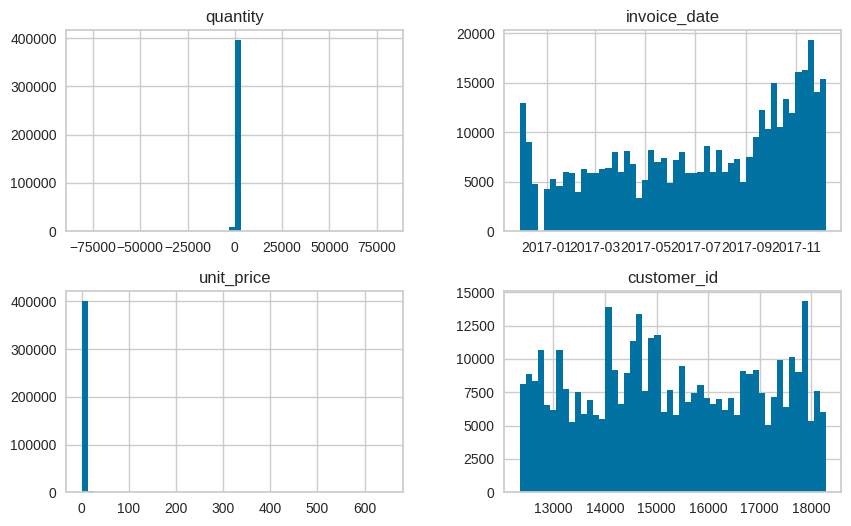

In [95]:
df2.hist(bins=50, figsize=(10,6))

array([[<Axes: title={'center': 'customer_id'}>,
        <Axes: title={'center': 'gross_revenue'}>],
       [<Axes: title={'center': 'recency'}>,
        <Axes: title={'center': 'invoice_no'}>],
       [<Axes: title={'center': 'avg_ticket'}>,
        <Axes: title={'center': 'returns'}>]], dtype=object)

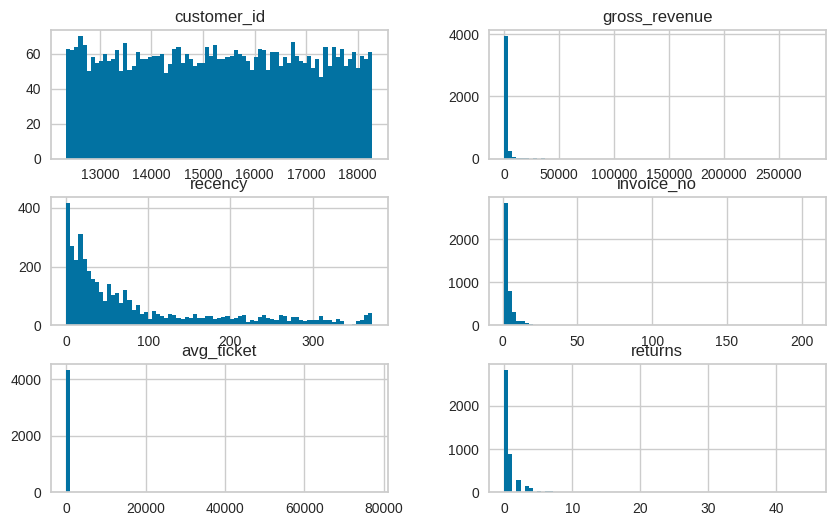

In [96]:
df_ref.hist(bins=75, figsize=(10,6))

In [98]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency          0
invoice_no       0
avg_ticket       0
returns          0
dtype: int64

# 5. Data Preparation

In [122]:
df5 = df4.copy()

In [123]:
std_scaler =StandardScaler()

df5['gross_revenue'] = std_scaler.fit_transform(df5[['gross_revenue']])
df5['recency'] = std_scaler.fit_transform(df5[['recency']])
df5['invoice_no'] = std_scaler.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = std_scaler.fit_transform(df5[['avg_ticket']])
#df5['returns'] = std_scaler.fit_transform(df5[['returns']])

# 6. Feature Selection

In [ ]:
df6 = df5.copy()

# 7. Hyperparameter Fine Tunning

In [124]:
df7 = df5.drop(columns=['returns'])
df7.head()

,customer_id,gross_revenue,recency,invoice_no,avg_ticket
0,17850,0.377090,2.792373,3.891186,-0.033940
1,13047,0.135315,-0.361041,0.621390,-0.033428
2,12583,0.524283,-0.899915,1.406141,-0.026624
3,13748,-0.120541,0.028146,0.098222,-0.023246
4,15100,-0.128634,2.403186,-0.163361,0.152421


In [115]:
df7.describe()

,gross_revenue,recency,invoice_no,avg_ticket
count,4329.000000,4329.000000,4329.000000,4329.000000
mean,2024.469007,92.179487,4.249018,68.024719
std,8929.244244,100.220427,7.646619,1469.621573
min,3.750000,0.000000,1.000000,2.101286
25%,305.750000,17.000000,1.000000,12.255816
50%,668.140000,50.000000,2.000000,17.562566
75%,1633.780000,142.000000,5.000000,24.627059
max,279138.020000,373.000000,206.000000,77183.600000


## 7.1. Within-Cluster Sum of Squares (WSS)

Returns the compactness of the clusters. It is global measure and does not tell if the clusters are well separated or if there is overlaping between them.

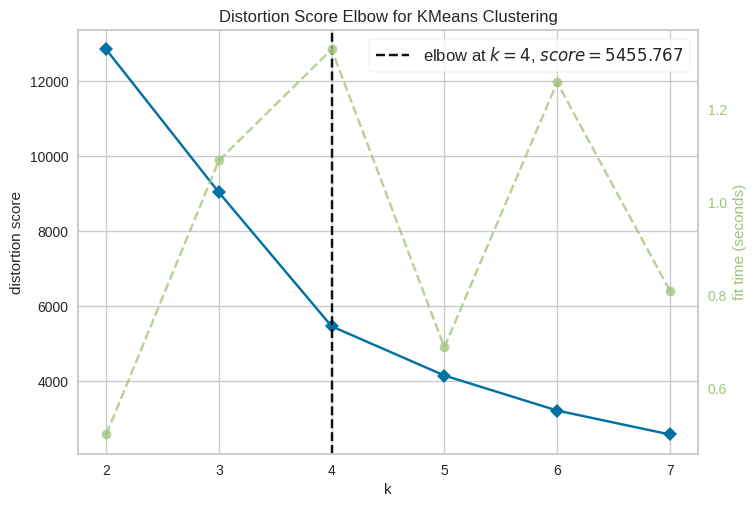

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [107]:
clusters = [2, 3, 4, 5, 6, 7]
model = KMeans(n_init=10)
elbow = KElbowVisualizer(estimator=model, k=clusters)
elbow.fit(df7)
elbow.show()

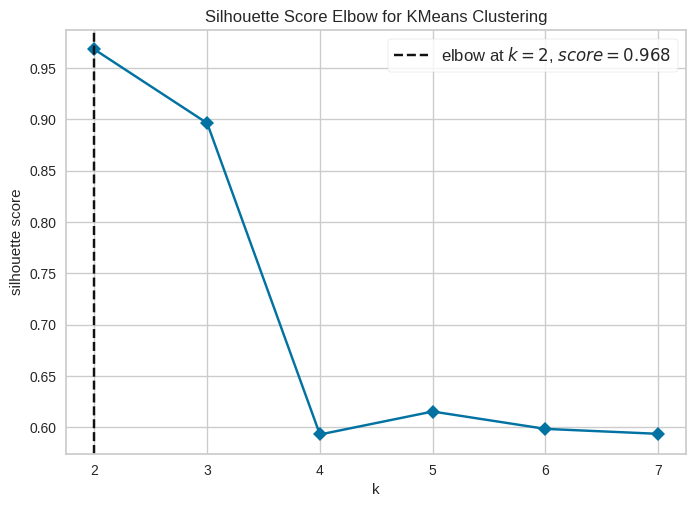

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [108]:
S = KElbowVisualizer(estimator=model, k=clusters, metric='silhouette', timings=False)
S.fit(df7)
S.show()

## 7.2. Silhouette Analysis

Measures how well a point fits into its cluster compared to the others.

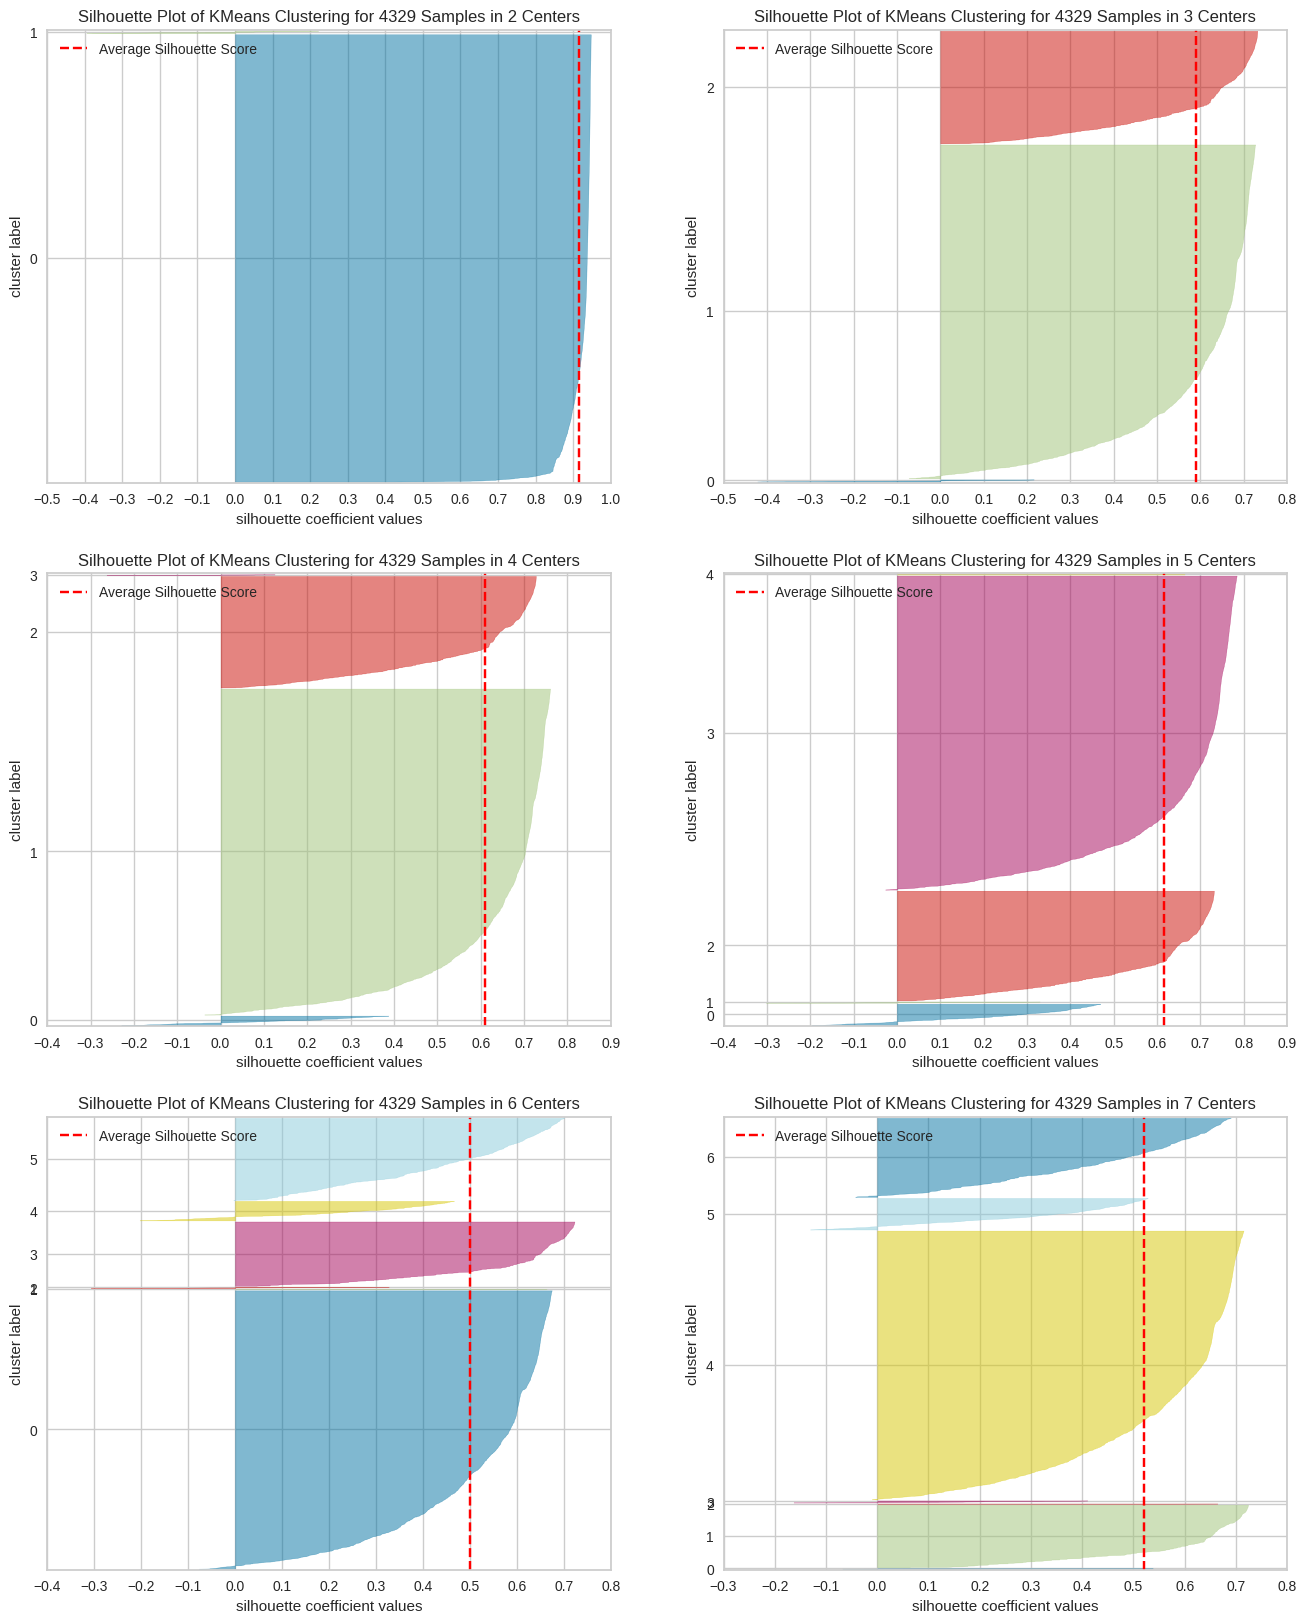

In [109]:
fig, ax = plt.subplots(3,2, figsize=(16,20))

for k in clusters:
    km_model = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    x, y = divmod(k, 2)
    SS = SilhouetteVisualizer(estimator=km_model, colors='yellowbrick', ax=ax[x-1][y])
    SS.fit(df7)
    SS.finalize()
    #SS.show()

# 8. Model Training

## 8.1. K-Means

In [111]:
k = 3

kmeans = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=42)
kmeans.fit(df7)
labels = kmeans.predict(df7)

### 8.1.1. Validation

In [112]:
# WSS
print(f'WSS: {kmeans.inertia_}')

# SS
print(f'Silhouette score: {silhouette_score(X=df7, labels=labels, metric="euclidean")}')

WSS: 9402.550834440599


Silhouette score: 0.5895445407991586


# 9. Cluster Analisys

In [125]:
df9 = df7.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency,invoice_no,avg_ticket,cluster
0,17850,0.377090,2.792373,3.891186,-0.033940,2
1,13047,0.135315,-0.361041,0.621390,-0.033428,1
2,12583,0.524283,-0.899915,1.406141,-0.026624,1
3,13748,-0.120541,0.028146,0.098222,-0.023246,1
4,15100,-0.128634,2.403186,-0.163361,0.152421,2


## 9.1. Visualization

In [126]:
df7.head()

,customer_id,gross_revenue,recency,invoice_no,avg_ticket
0,17850,0.377090,2.792373,3.891186,-0.033940
1,13047,0.135315,-0.361041,0.621390,-0.033428
2,12583,0.524283,-0.899915,1.406141,-0.026624
3,13748,-0.120541,0.028146,0.098222,-0.023246
4,15100,-0.128634,2.403186,-0.163361,0.152421


/home/ezequiel/.pyenv/versions/ins_clustering/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


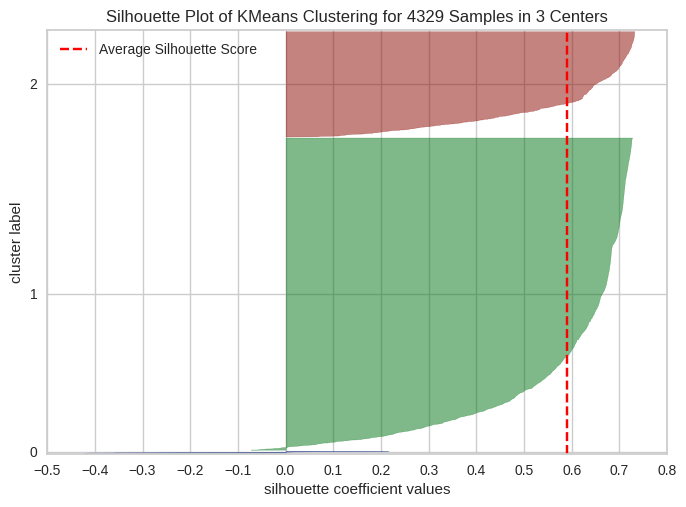

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4329 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [114]:
SS_fig = SilhouetteVisualizer(kmeans, colors='sns_dark')
SS_fig.fit(df7)
SS_fig.show()

In [ ]:
#fig = px.scatter_3d(data_frame=df9, x='gross_revenue', y='recency', z='invoice_no', color='cluster', width=600, height=600)
#fig.show()

In [136]:
df9.head()

,gross_revenue,recency,invoice_no,avg_ticket,returns,cluster
0,0.378347,2.793160,3.897513,-0.033914,0.114982,5
1,0.135982,-0.361673,0.622737,-0.033402,3.159792,4
2,0.525899,-0.900791,1.408683,-0.026594,0.622451,4
3,-0.120499,0.027689,0.098772,-0.023214,-0.392486,0
4,-0.128611,2.403798,-0.163210,0.152554,1.129919,5


### 9.1.1. 2d plot

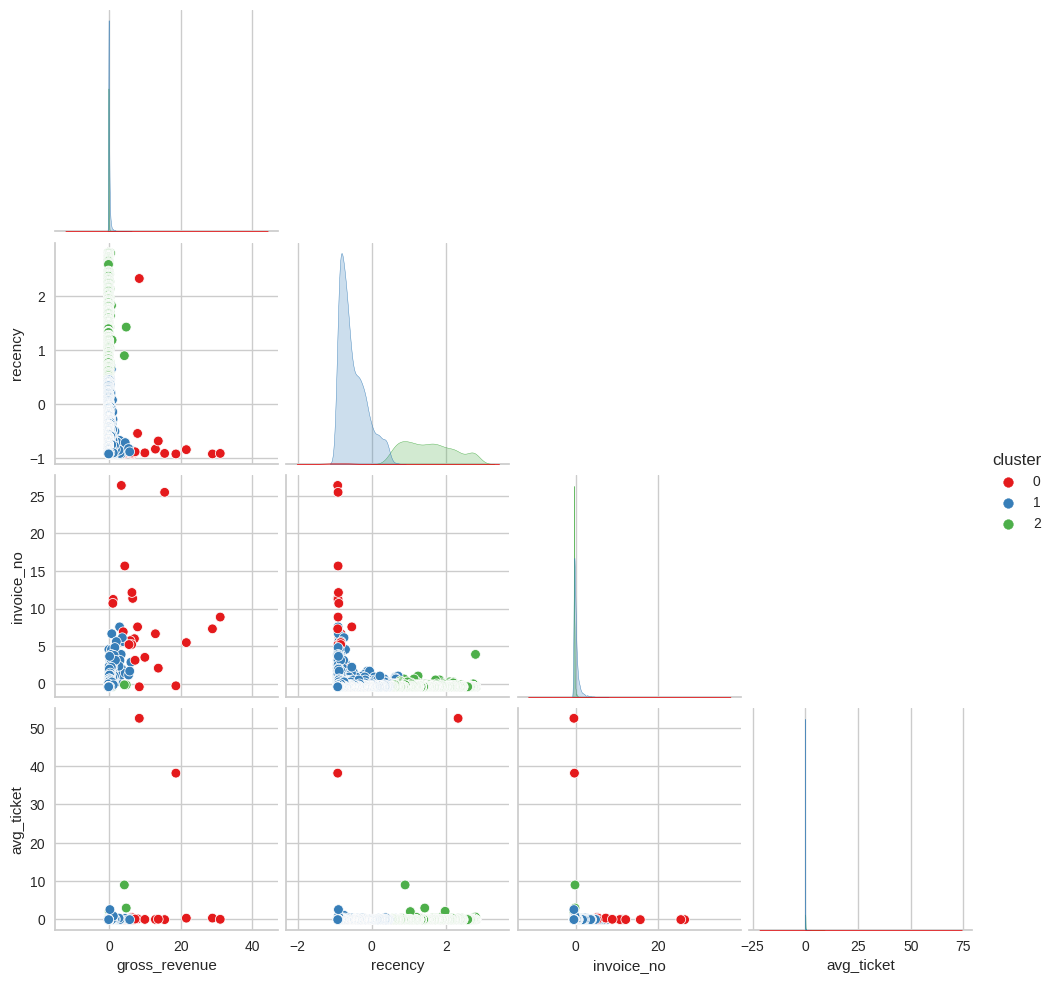

In [127]:
df_viz = df9.drop(columns='customer_id')
sns.pairplot(data=df_viz, hue='cluster', corner=True, palette='Set1')

### 9.1.2. UMAP

Ferramenta para visualização de dados com alta dimensionalidade em um plano 2D.
- Clusters com boa definição (bom agrupamento) em 2D indicam um bom agrupamento na alta dimensionalidade

In [126]:
df9.head()

,gross_revenue,recency,invoice_no,avg_ticket,cluster
0,5391.21,372.0,34.0,18.152222,2
1,3232.59,56.0,9.0,18.904035,1
2,6705.38,2.0,15.0,28.902500,2
3,948.25,95.0,5.0,33.866071,1
4,876.00,333.0,3.0,292.000000,1


In [128]:
reducer = umap.UMAP(n_neighbors=90, n_jobs=-1)
embedding = reducer.fit_transform(df9)

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

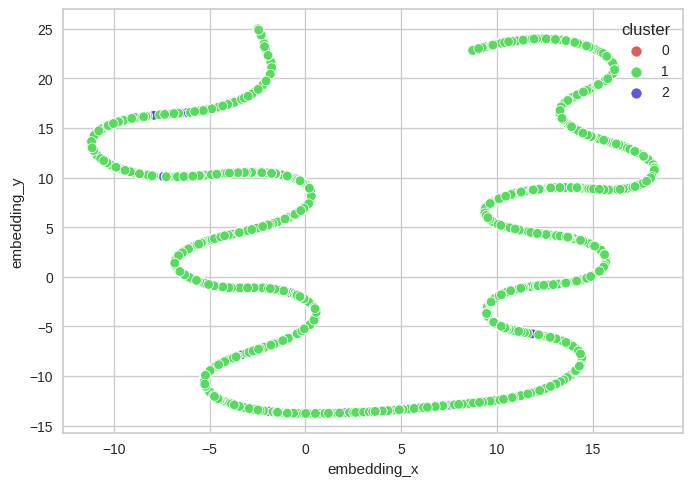

In [129]:
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

## 9.2. Cluster profile

In [136]:
df9['gross_revenue'].sum()

0.0

In [135]:
df9[['cluster', 'gross_revenue']].groupby('cluster').sum() / df9['gross_revenue'].sum()

,gross_revenue
cluster,
0,inf
1,-inf
2,-inf


In [130]:
# Number of customers
df_clusters = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()

# Number of customers (%)
df_clusters['% customer_id'] = (df_clusters[['customer_id']] / df_clusters[['customer_id']].sum()) * 100

# Average gross revenue
aux1 = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()

# % Gross revenue
aux2 = (df9[['cluster', 'gross_revenue']].groupby('cluster').sum() / df9['gross_revenue'].sum()).reset_index().rename(columns={'gross_revenue': '% gross_revenue'})

# Average recency
aux3 = df9[['recency', 'cluster']].groupby('cluster').mean().reset_index()

# Average invoice no
aux4 = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()

# Average ticket
aux5 = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()

In [131]:
df_clusters = pd.merge(df_clusters, aux1, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux2, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux3, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux4, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux5, on='cluster', how='left')
df_clusters

,cluster,customer_id,% customer_id,gross_revenue,% gross_revenue,recency,invoice_no,avg_ticket
0,0,22,0.508201,10.334031,inf,-0.722559,8.439176,4.188972
1,1,3221,74.405174,-0.015107,-inf,-0.513901,0.060459,-0.025685
2,2,1086,25.086625,-0.164538,-inf,1.538831,-0.350276,-0.008678


---

**Cluster 1 (candidatos à insiders)**:
- Número de customers: 267 (6,1%)
- Recência média: 20,28
- Média de compras: 19,5
- Média de receita: US$ 8.089,00
- Ticket médio: US$ 62,78
---

**Cluster 2**:
- Número de customers: 6 (0,14%)
- Recência média: 7,16
- Média de compras: 89
- Média de receita: US$ 182.181,98
- Ticket médio: US$ 253,62
---

**Cluster 3**:
- Número de customers: 28 (0,64%)
- Recência média: 6,18
- Média de compras: 57,82
- Média de receita: US$ 42.614,39
- Ticket médio: US$ 162,86
---

**Cluster 4**:
- Número de customers: 4071 (93,1%)
- Recência média: 96,96
- Média de compras: 3,64
- Média de receita: US$ 946,69
- Ticket médio: US$ 25,35
---

# 10. Deploy to Production